In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,AveragePooling2D,Dropout,LayerNormalization, ReLU,concatenate,Cropping2D, BatchNormalization

from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


2024-07-18 12:20:48.252721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [4]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [5]:
df['txt_content'].str.len().value_counts()

txt_content
6    7997
7       3
Name: count, dtype: int64

In [6]:
def generate_clean_captcha(text):
    # Fixed parameters
    size = (50, 180)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    num_parts = 7

    # Create a blank white image
    image = np.ones((*size, 1), dtype=np.uint8) * 255  # White background

    # Calculate positions for each part
    part_width = size[1] / num_parts
    vertical_positions = [int(part_width * i + part_width / 2) for i in range(num_parts)]
    vertical_positions = vertical_positions[:len(text)]  # Adjust to the length of the text

    # Calculate y position to center the text vertically
    text_y = int((size[0] + cv2.getTextSize(text, font, font_scale, font_thickness)[0][1]) / 2)

    # Draw each letter at the calculated position
    for char, x in zip(text, vertical_positions):
        char_size, _ = cv2.getTextSize(char, font, font_scale, font_thickness)
        char_x = x - char_size[0] // 2  # Center the character horizontally within its part
        cv2.putText(image, char, (char_x, text_y), font, font_scale, (0,), font_thickness, lineType=cv2.LINE_AA)
    return image

In [7]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [8]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)

  Y = np.array([generate_clean_captcha(x) for x in df["txt_content"]])
  X = X.astype('float32') / 255.
  Y = Y.astype('float32') / 255.
  return X,Y

X_train, Y_train = generate_X_Y('../dados/CAPTCHA-10k/treinamento')
X_val, Y_val = generate_X_Y('../dados/CAPTCHA-10k/validacao')

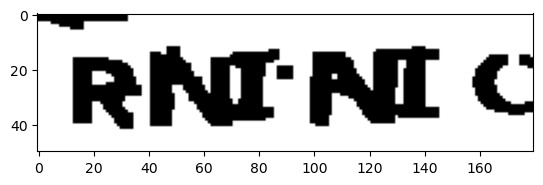

In [9]:
plt.imshow(X_train[0], cmap='gray')

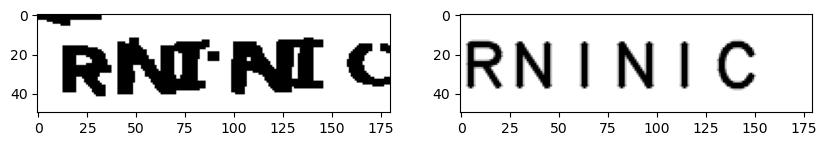

In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')

# Display the corresponding Y_train[0]
plt.subplot(1, 2, 2)
plt.imshow(Y_train[0], cmap='gray')
plt.show()

In [11]:
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)
batch_size = 64
augmented_data_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)

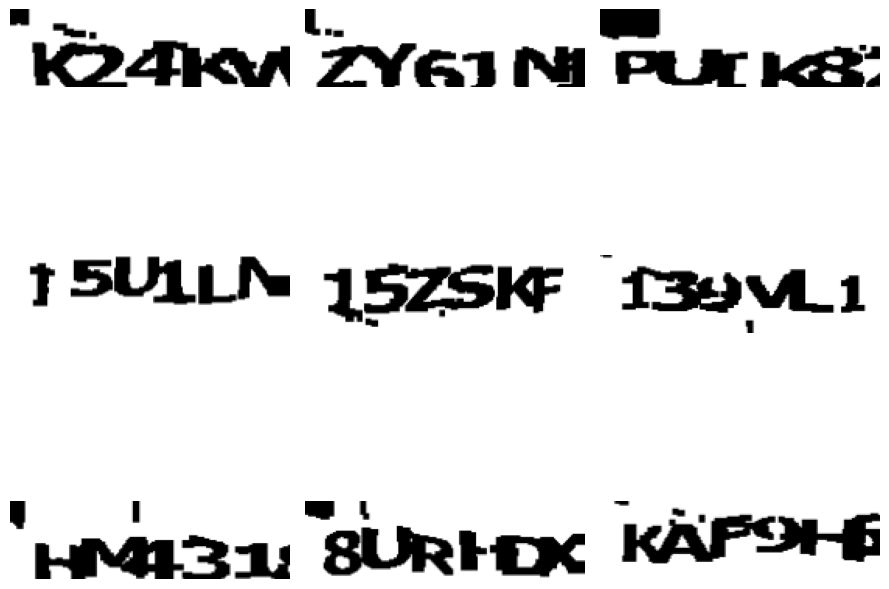

In [12]:
augmented_images, augmented_labels = next(augmented_data_generator)

# Display the first few augmented images and their corresponding labels
plt.figure(figsize=(9, 9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].reshape(50, 180), cmap='gray')  # Assuming images are grayscale
    plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [14]:
def conv_bn_relu(filters, kernel_size, strides=(1, 1), padding='same'):
    def layer(x):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x
    return layer

In [15]:
def crop_and_concat(x1, x2):
    # Crop x2 to the shape of x1
    x1_shape = x1.shape
    x2_shape = x2.shape
    height_diff = x2_shape[1] - x1_shape[1]
    width_diff = x2_shape[2] - x1_shape[2]

    cropping = ((height_diff // 2, height_diff - height_diff // 2),
                (width_diff // 2, width_diff - width_diff // 2))
    x2_cropped = Cropping2D(cropping)(x2)
    return concatenate([x1, x2_cropped])

In [16]:
def u_net(input_img, num_blocks=1, num_downsample=3):
    x = input_img

    for _ in range(2):
        x = conv_bn_relu(64, (3, 3))(x)

    # Contracting path
    res = []
    for _ in range(num_downsample):
        for _ in range(num_blocks):
            x = conv_bn_relu(32, (3, 3))(x)
        res.append(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck
    for _ in range(num_blocks):
        x = conv_bn_relu(32, (3, 3))(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    
    shape_before_flattening = x.shape[1:]
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)

    x = Dense(np.prod(shape_before_flattening), activation='relu')(x)
    x = Reshape(shape_before_flattening)(x)

    # Expansive path
    for i in range(num_downsample - 1, -1, -1):
        x = UpSampling2D((2, 2))(x)
        x = crop_and_concat(res[i],x)
        for _ in range(num_blocks):
            x = conv_bn_relu(32, (3, 3))(x)
    
    for _ in range(num_blocks):
        x = conv_bn_relu(32, (3, 3))(x)

    output = Conv2D(1, (1, 1), activation='sigmoid')(x)
    return tf.keras.Model(inputs=input_img, outputs=output)


input_shape = (50, 180, 1)  # Example input shape
input_img = Input(shape=input_shape)
autoencoder = u_net(input_img, num_blocks=3, num_downsample=4)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rmse,psnr])
autoencoder.summary()

2024-07-18 12:20:53.661901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13742 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 180, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 180, 64)          640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 50, 180, 64)          256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 50, 180, 64)          0         ['batch_normalization[0][0

In [17]:
checkpoint = ModelCheckpoint(
    'model_BCE_aug_best_unet.tf',
    monitor='val_rmse',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [18]:
history = autoencoder.fit(augmented_data_generator,
                steps_per_epoch=len(X_train) // batch_size,
                epochs=300,
                batch_size=batch_size,
                shuffle=True,
                callbacks=[checkpoint],
                validation_data=(X_val, Y_val))

Epoch 1/300


2024-07-18 12:21:01.727196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-07-18 12:21:03.146939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-18 12:21:03.627972: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x77590ca26fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-18 12:21:03.628013: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-07-18 12:21:03.633487: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-18 12:21:03.752122: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

125/125 [==============================] - ETA: 0s - loss: 0.3107 - rmse: 0.2802 - psnr: 11.2431
Epoch 1: val_rmse improved from inf to 0.26080, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 54s 267ms/step - loss: 0.3107 - rmse: 0.2802 - psnr: 11.2431 - val_loss: 0.2880 - val_rmse: 0.2608 - val_psnr: 11.6844
Epoch 2/300
125/125 [==============================] - ETA: 0s - loss: 0.2097 - rmse: 0.2308 - psnr: 12.7568
Epoch 2: val_rmse improved from 0.26080 to 0.25925, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 242ms/step - loss: 0.2097 - rmse: 0.2308 - psnr: 12.7568 - val_loss: 0.2603 - val_rmse: 0.2592 - val_psnr: 11.7744
Epoch 3/300
125/125 [==============================] - ETA: 0s - loss: 0.1642 - rmse: 0.1966 - psnr: 14.2177
Epoch 3: val_rmse did not improve from 0.25925
125/125 [==============================] - 21s 164ms/step - loss: 0.1642 - rmse: 0.1966 - psnr: 14.2177 - val_loss: 0.2626 - val_rmse: 0.2647 - val_psnr: 11.5726
Epoch 4/300
125/125 [==============================] - ETA: 0s - loss: 0.1301 - rmse: 0.1659 - psnr: 15.7870
Epoch 4: val_rmse improved from 0.25925 to 0.22961, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 29s 233ms/step - loss: 0.1301 - rmse: 0.1659 - psnr: 15.7870 - val_loss: 0.2162 - val_rmse: 0.2296 - val_psnr: 12.8977
Epoch 5/300
125/125 [==============================] - ETA: 0s - loss: 0.1086 - rmse: 0.1441 - psnr: 17.1071
Epoch 5: val_rmse improved from 0.22961 to 0.17133, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 242ms/step - loss: 0.1086 - rmse: 0.1441 - psnr: 17.1071 - val_loss: 0.1390 - val_rmse: 0.1713 - val_psnr: 15.7017
Epoch 6/300
125/125 [==============================] - ETA: 0s - loss: 0.0931 - rmse: 0.1264 - psnr: 18.4129
Epoch 6: val_rmse improved from 0.17133 to 0.12068, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 242ms/step - loss: 0.0931 - rmse: 0.1264 - psnr: 18.4129 - val_loss: 0.0897 - val_rmse: 0.1207 - val_psnr: 18.7747
Epoch 7/300
125/125 [==============================] - ETA: 0s - loss: 0.0835 - rmse: 0.1143 - psnr: 19.4560
Epoch 7: val_rmse improved from 0.12068 to 0.09863, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 31s 246ms/step - loss: 0.0835 - rmse: 0.1143 - psnr: 19.4560 - val_loss: 0.0731 - val_rmse: 0.0986 - val_psnr: 20.6350
Epoch 8/300
125/125 [==============================] - ETA: 0s - loss: 0.0764 - rmse: 0.1045 - psnr: 20.4320
Epoch 8: val_rmse improved from 0.09863 to 0.09839, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 241ms/step - loss: 0.0764 - rmse: 0.1045 - psnr: 20.4320 - val_loss: 0.0734 - val_rmse: 0.0984 - val_psnr: 20.8428
Epoch 9/300
125/125 [==============================] - ETA: 0s - loss: 0.0720 - rmse: 0.0982 - psnr: 21.1294
Epoch 9: val_rmse did not improve from 0.09839
125/125 [==============================] - 20s 163ms/step - loss: 0.0720 - rmse: 0.0982 - psnr: 21.1294 - val_loss: 0.0745 - val_rmse: 0.1019 - val_psnr: 20.4025
Epoch 10/300
125/125 [==============================] - ETA: 0s - loss: 0.0681 - rmse: 0.0922 - psnr: 21.9008
Epoch 10: val_rmse improved from 0.09839 to 0.09252, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 240ms/step - loss: 0.0681 - rmse: 0.0922 - psnr: 21.9008 - val_loss: 0.0688 - val_rmse: 0.0925 - val_psnr: 21.7174
Epoch 11/300
125/125 [==============================] - ETA: 0s - loss: 0.0658 - rmse: 0.0884 - psnr: 22.4432
Epoch 11: val_rmse improved from 0.09252 to 0.08113, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 243ms/step - loss: 0.0658 - rmse: 0.0884 - psnr: 22.4432 - val_loss: 0.0617 - val_rmse: 0.0811 - val_psnr: 22.9849
Epoch 12/300
125/125 [==============================] - ETA: 0s - loss: 0.0638 - rmse: 0.0854 - psnr: 22.9163
Epoch 12: val_rmse improved from 0.08113 to 0.08005, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 238ms/step - loss: 0.0638 - rmse: 0.0854 - psnr: 22.9163 - val_loss: 0.0611 - val_rmse: 0.0800 - val_psnr: 23.1893
Epoch 13/300
125/125 [==============================] - ETA: 0s - loss: 0.0623 - rmse: 0.0828 - psnr: 23.3874
Epoch 13: val_rmse improved from 0.08005 to 0.07092, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 31s 246ms/step - loss: 0.0623 - rmse: 0.0828 - psnr: 23.3874 - val_loss: 0.0565 - val_rmse: 0.0709 - val_psnr: 24.4227
Epoch 14/300
125/125 [==============================] - ETA: 0s - loss: 0.0610 - rmse: 0.0805 - psnr: 23.7636
Epoch 14: val_rmse did not improve from 0.07092
125/125 [==============================] - 20s 163ms/step - loss: 0.0610 - rmse: 0.0805 - psnr: 23.7636 - val_loss: 0.0647 - val_rmse: 0.0855 - val_psnr: 22.6083
Epoch 15/300
125/125 [==============================] - ETA: 0s - loss: 0.0599 - rmse: 0.0785 - psnr: 24.1094
Epoch 15: val_rmse improved from 0.07092 to 0.06775, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 241ms/step - loss: 0.0599 - rmse: 0.0785 - psnr: 24.1094 - val_loss: 0.0551 - val_rmse: 0.0677 - val_psnr: 25.1898
Epoch 16/300
125/125 [==============================] - ETA: 0s - loss: 0.0589 - rmse: 0.0766 - psnr: 24.4373
Epoch 16: val_rmse did not improve from 0.06775
125/125 [==============================] - 21s 166ms/step - loss: 0.0589 - rmse: 0.0766 - psnr: 24.4373 - val_loss: 0.0556 - val_rmse: 0.0692 - val_psnr: 25.2601
Epoch 17/300
125/125 [==============================] - ETA: 0s - loss: 0.0580 - rmse: 0.0751 - psnr: 24.7654
Epoch 17: val_rmse did not improve from 0.06775
125/125 [==============================] - 21s 166ms/step - loss: 0.0580 - rmse: 0.0751 - psnr: 24.7654 - val_loss: 0.0567 - val_rmse: 0.0720 - val_psnr: 24.5043
Epoch 18/300
125/125 [==============================] - ETA: 0s - loss: 0.0581 - rmse: 0.0754 - psnr: 24.7602
Epoch 18: val_rmse did not improve from 0.06775
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 242ms/step - loss: 0.0571 - rmse: 0.0733 - psnr: 25.2014 - val_loss: 0.0522 - val_rmse: 0.0613 - val_psnr: 26.8397
Epoch 20/300
125/125 [==============================] - ETA: 0s - loss: 0.0569 - rmse: 0.0728 - psnr: 25.3343
Epoch 20: val_rmse did not improve from 0.06127
125/125 [==============================] - 21s 164ms/step - loss: 0.0569 - rmse: 0.0728 - psnr: 25.3343 - val_loss: 0.0614 - val_rmse: 0.0792 - val_psnr: 24.1957
Epoch 21/300
125/125 [==============================] - ETA: 0s - loss: 0.0559 - rmse: 0.0708 - psnr: 25.7349
Epoch 21: val_rmse did not improve from 0.06127
125/125 [==============================] - 21s 166ms/step - loss: 0.0559 - rmse: 0.0708 - psnr: 25.7349 - val_loss: 0.0522 - val_rmse: 0.0622 - val_psnr: 26.3096
Epoch 22/300
125/125 [==============================] - ETA: 0s - loss: 0.0561 - rmse: 0.0715 - psnr: 25.7028
Epoch 22: val_rmse improved from 0.06127 to 0.05726, saving model to model_BCE_aug_best_

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 238ms/step - loss: 0.0561 - rmse: 0.0715 - psnr: 25.7028 - val_loss: 0.0503 - val_rmse: 0.0573 - val_psnr: 27.5211
Epoch 23/300
125/125 [==============================] - ETA: 0s - loss: 0.0560 - rmse: 0.0712 - psnr: 25.7236
Epoch 23: val_rmse did not improve from 0.05726
125/125 [==============================] - 21s 165ms/step - loss: 0.0560 - rmse: 0.0712 - psnr: 25.7236 - val_loss: 0.0581 - val_rmse: 0.0749 - val_psnr: 24.4578
Epoch 24/300
125/125 [==============================] - ETA: 0s - loss: 0.0546 - rmse: 0.0683 - psnr: 26.3173
Epoch 24: val_rmse improved from 0.05726 to 0.05506, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 242ms/step - loss: 0.0546 - rmse: 0.0683 - psnr: 26.3173 - val_loss: 0.0492 - val_rmse: 0.0551 - val_psnr: 28.3429
Epoch 25/300
125/125 [==============================] - ETA: 0s - loss: 0.0543 - rmse: 0.0674 - psnr: 26.5365
Epoch 25: val_rmse did not improve from 0.05506
125/125 [==============================] - 21s 164ms/step - loss: 0.0543 - rmse: 0.0674 - psnr: 26.5365 - val_loss: 0.0502 - val_rmse: 0.0576 - val_psnr: 27.5829
Epoch 26/300
125/125 [==============================] - ETA: 0s - loss: 0.0537 - rmse: 0.0662 - psnr: 26.8550
Epoch 26: val_rmse did not improve from 0.05506
125/125 [==============================] - 20s 162ms/step - loss: 0.0537 - rmse: 0.0662 - psnr: 26.8550 - val_loss: 0.0595 - val_rmse: 0.0784 - val_psnr: 24.3214
Epoch 27/300
125/125 [==============================] - ETA: 0s - loss: 0.0542 - rmse: 0.0673 - psnr: 26.6635
Epoch 27: val_rmse did not improve from 0.05506
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 242ms/step - loss: 0.0519 - rmse: 0.0620 - psnr: 28.1165 - val_loss: 0.0493 - val_rmse: 0.0550 - val_psnr: 28.2770
Epoch 40/300
125/125 [==============================] - ETA: 0s - loss: 0.0517 - rmse: 0.0617 - psnr: 28.2808
Epoch 40: val_rmse did not improve from 0.05496
125/125 [==============================] - 20s 160ms/step - loss: 0.0517 - rmse: 0.0617 - psnr: 28.2808 - val_loss: 0.0502 - val_rmse: 0.0561 - val_psnr: 28.9525
Epoch 41/300
125/125 [==============================] - ETA: 0s - loss: 0.0517 - rmse: 0.0618 - psnr: 28.2091
Epoch 41: val_rmse did not improve from 0.05496
125/125 [==============================] - 20s 162ms/step - loss: 0.0517 - rmse: 0.0618 - psnr: 28.2091 - val_loss: 0.0506 - val_rmse: 0.0580 - val_psnr: 28.3254
Epoch 42/300
125/125 [==============================] - ETA: 0s - loss: 0.0519 - rmse: 0.0625 - psnr: 28.2636
Epoch 42: val_rmse did not improve from 0.05496
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 29s 233ms/step - loss: 0.0514 - rmse: 0.0610 - psnr: 28.5642 - val_loss: 0.0491 - val_rmse: 0.0542 - val_psnr: 29.1558
Epoch 44/300
125/125 [==============================] - ETA: 0s - loss: 0.0511 - rmse: 0.0604 - psnr: 28.7694
Epoch 44: val_rmse improved from 0.05419 to 0.05219, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 238ms/step - loss: 0.0511 - rmse: 0.0604 - psnr: 28.7694 - val_loss: 0.0483 - val_rmse: 0.0522 - val_psnr: 29.8811
Epoch 45/300
125/125 [==============================] - ETA: 0s - loss: 0.0513 - rmse: 0.0609 - psnr: 28.5977
Epoch 45: val_rmse improved from 0.05219 to 0.05087, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 29s 235ms/step - loss: 0.0513 - rmse: 0.0609 - psnr: 28.5977 - val_loss: 0.0481 - val_rmse: 0.0509 - val_psnr: 29.5898
Epoch 46/300
125/125 [==============================] - ETA: 0s - loss: 0.0507 - rmse: 0.0593 - psnr: 29.0744
Epoch 46: val_rmse did not improve from 0.05087
125/125 [==============================] - 20s 158ms/step - loss: 0.0507 - rmse: 0.0593 - psnr: 29.0744 - val_loss: 0.0488 - val_rmse: 0.0531 - val_psnr: 29.9229
Epoch 47/300
125/125 [==============================] - ETA: 0s - loss: 0.0512 - rmse: 0.0603 - psnr: 28.8313
Epoch 47: val_rmse improved from 0.05087 to 0.04964, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 29s 234ms/step - loss: 0.0512 - rmse: 0.0603 - psnr: 28.8313 - val_loss: 0.0476 - val_rmse: 0.0496 - val_psnr: 31.1775
Epoch 48/300
125/125 [==============================] - ETA: 0s - loss: 0.0511 - rmse: 0.0604 - psnr: 28.6996
Epoch 48: val_rmse did not improve from 0.04964
125/125 [==============================] - 20s 162ms/step - loss: 0.0511 - rmse: 0.0604 - psnr: 28.6996 - val_loss: 0.0485 - val_rmse: 0.0529 - val_psnr: 29.7233
Epoch 49/300
125/125 [==============================] - ETA: 0s - loss: 0.0507 - rmse: 0.0594 - psnr: 29.0039
Epoch 49: val_rmse improved from 0.04964 to 0.04798, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 28s 226ms/step - loss: 0.0507 - rmse: 0.0594 - psnr: 29.0039 - val_loss: 0.0467 - val_rmse: 0.0480 - val_psnr: 30.5892
Epoch 50/300
125/125 [==============================] - ETA: 0s - loss: 0.0506 - rmse: 0.0593 - psnr: 29.2192
Epoch 50: val_rmse did not improve from 0.04798
125/125 [==============================] - 20s 160ms/step - loss: 0.0506 - rmse: 0.0593 - psnr: 29.2192 - val_loss: 0.0474 - val_rmse: 0.0504 - val_psnr: 29.9663
Epoch 51/300
125/125 [==============================] - ETA: 0s - loss: 0.0507 - rmse: 0.0593 - psnr: 29.2178
Epoch 51: val_rmse did not improve from 0.04798
125/125 [==============================] - 20s 162ms/step - loss: 0.0507 - rmse: 0.0593 - psnr: 29.2178 - val_loss: 0.0479 - val_rmse: 0.0506 - val_psnr: 30.5798
Epoch 52/300
125/125 [==============================] - ETA: 0s - loss: 0.0506 - rmse: 0.0593 - psnr: 29.3268
Epoch 52: val_rmse did not improve from 0.04798
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 29s 236ms/step - loss: 0.0489 - rmse: 0.0549 - psnr: 30.7078 - val_loss: 0.0465 - val_rmse: 0.0471 - val_psnr: 31.3810
Epoch 72/300
125/125 [==============================] - ETA: 0s - loss: 0.0489 - rmse: 0.0552 - psnr: 30.5839
Epoch 72: val_rmse improved from 0.04711 to 0.04464, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 240ms/step - loss: 0.0489 - rmse: 0.0552 - psnr: 30.5839 - val_loss: 0.0456 - val_rmse: 0.0446 - val_psnr: 32.8733
Epoch 73/300
125/125 [==============================] - ETA: 0s - loss: 0.0487 - rmse: 0.0548 - psnr: 30.8859
Epoch 73: val_rmse did not improve from 0.04464
125/125 [==============================] - 20s 161ms/step - loss: 0.0487 - rmse: 0.0548 - psnr: 30.8859 - val_loss: 0.0466 - val_rmse: 0.0476 - val_psnr: 32.5341
Epoch 74/300
125/125 [==============================] - ETA: 0s - loss: 0.0488 - rmse: 0.0549 - psnr: 30.8486
Epoch 74: val_rmse did not improve from 0.04464
125/125 [==============================] - 20s 161ms/step - loss: 0.0488 - rmse: 0.0549 - psnr: 30.8486 - val_loss: 0.0459 - val_rmse: 0.0454 - val_psnr: 32.5665
Epoch 75/300
125/125 [==============================] - ETA: 0s - loss: 0.0489 - rmse: 0.0552 - psnr: 30.6267
Epoch 75: val_rmse did not improve from 0.04464
125/125 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 29s 230ms/step - loss: 0.0468 - rmse: 0.0503 - psnr: 32.3446 - val_loss: 0.0455 - val_rmse: 0.0445 - val_psnr: 34.0185
Epoch 113/300
125/125 [==============================] - ETA: 0s - loss: 0.0470 - rmse: 0.0507 - psnr: 32.4532
Epoch 113: val_rmse did not improve from 0.04446
125/125 [==============================] - 20s 158ms/step - loss: 0.0470 - rmse: 0.0507 - psnr: 32.4532 - val_loss: 0.0483 - val_rmse: 0.0512 - val_psnr: 31.7062
Epoch 114/300
125/125 [==============================] - ETA: 0s - loss: 0.0468 - rmse: 0.0500 - psnr: 32.5235
Epoch 114: val_rmse did not improve from 0.04446
125/125 [==============================] - 20s 159ms/step - loss: 0.0468 - rmse: 0.0500 - psnr: 32.5235 - val_loss: 0.0460 - val_rmse: 0.0448 - val_psnr: 34.6641
Epoch 115/300
125/125 [==============================] - ETA: 0s - loss: 0.0467 - rmse: 0.0496 - psnr: 32.6751
Epoch 115: val_rmse did not improve from 0.04446
125/125 [=========================

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 240ms/step - loss: 0.0460 - rmse: 0.0480 - psnr: 33.2782 - val_loss: 0.0456 - val_rmse: 0.0438 - val_psnr: 35.2998
Epoch 135/300
125/125 [==============================] - ETA: 0s - loss: 0.0459 - rmse: 0.0476 - psnr: 33.5229
Epoch 135: val_rmse did not improve from 0.04379
125/125 [==============================] - 20s 163ms/step - loss: 0.0459 - rmse: 0.0476 - psnr: 33.5229 - val_loss: 0.0467 - val_rmse: 0.0466 - val_psnr: 34.9394
Epoch 136/300
125/125 [==============================] - ETA: 0s - loss: 0.0459 - rmse: 0.0477 - psnr: 33.4955
Epoch 136: val_rmse improved from 0.04379 to 0.04369, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 237ms/step - loss: 0.0459 - rmse: 0.0477 - psnr: 33.4955 - val_loss: 0.0455 - val_rmse: 0.0437 - val_psnr: 35.2134
Epoch 137/300
125/125 [==============================] - ETA: 0s - loss: 0.0460 - rmse: 0.0481 - psnr: 33.3872
Epoch 137: val_rmse did not improve from 0.04369
125/125 [==============================] - 20s 161ms/step - loss: 0.0460 - rmse: 0.0481 - psnr: 33.3872 - val_loss: 0.0464 - val_rmse: 0.0453 - val_psnr: 34.4865
Epoch 138/300
125/125 [==============================] - ETA: 0s - loss: 0.0462 - rmse: 0.0487 - psnr: 33.1206
Epoch 138: val_rmse did not improve from 0.04369
125/125 [==============================] - 20s 161ms/step - loss: 0.0462 - rmse: 0.0487 - psnr: 33.1206 - val_loss: 0.0464 - val_rmse: 0.0459 - val_psnr: 34.5466
Epoch 139/300
125/125 [==============================] - ETA: 0s - loss: 0.0460 - rmse: 0.0481 - psnr: 33.3633
Epoch 139: val_rmse did not improve from 0.04369
125/125 [=========================

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 29s 232ms/step - loss: 0.0453 - rmse: 0.0465 - psnr: 34.2415 - val_loss: 0.0456 - val_rmse: 0.0427 - val_psnr: 35.7923
Epoch 175/300
125/125 [==============================] - ETA: 0s - loss: 0.0449 - rmse: 0.0449 - psnr: 34.7844
Epoch 175: val_rmse improved from 0.04268 to 0.04251, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 241ms/step - loss: 0.0449 - rmse: 0.0449 - psnr: 34.7844 - val_loss: 0.0458 - val_rmse: 0.0425 - val_psnr: 37.3262
Epoch 176/300
125/125 [==============================] - ETA: 0s - loss: 0.0451 - rmse: 0.0453 - psnr: 34.7415
Epoch 176: val_rmse did not improve from 0.04251
125/125 [==============================] - 20s 161ms/step - loss: 0.0451 - rmse: 0.0453 - psnr: 34.7415 - val_loss: 0.0490 - val_rmse: 0.0525 - val_psnr: 32.9574
Epoch 177/300
125/125 [==============================] - ETA: 0s - loss: 0.0451 - rmse: 0.0456 - psnr: 34.4359
Epoch 177: val_rmse did not improve from 0.04251
125/125 [==============================] - 20s 164ms/step - loss: 0.0451 - rmse: 0.0456 - psnr: 34.4359 - val_loss: 0.0459 - val_rmse: 0.0433 - val_psnr: 35.9695
Epoch 178/300
125/125 [==============================] - ETA: 0s - loss: 0.0447 - rmse: 0.0446 - psnr: 34.7132
Epoch 178: val_rmse did not improve from 0.04251
125/125 [=========================

KeyboardInterrupt: 

In [19]:
Y_train_pred = autoencoder.predict(X_train)
Y_val_pred = autoencoder.predict(X_val)

32/32 [==============================] - 2s 36ms/step


In [20]:
def display_images(images, Y, Y_pred, num_images=10):
    indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(20, 6))
    for i, idx in enumerate(indices):
        # Original images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[idx].reshape(50,180), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Ground truth labels (Y)
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(Y[idx].reshape(50, 180), cmap="gray")
        plt.title("Y")
        plt.axis("off")

        # Reconstructed images (Y_pred)
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(Y_pred[idx].reshape(50, 180), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

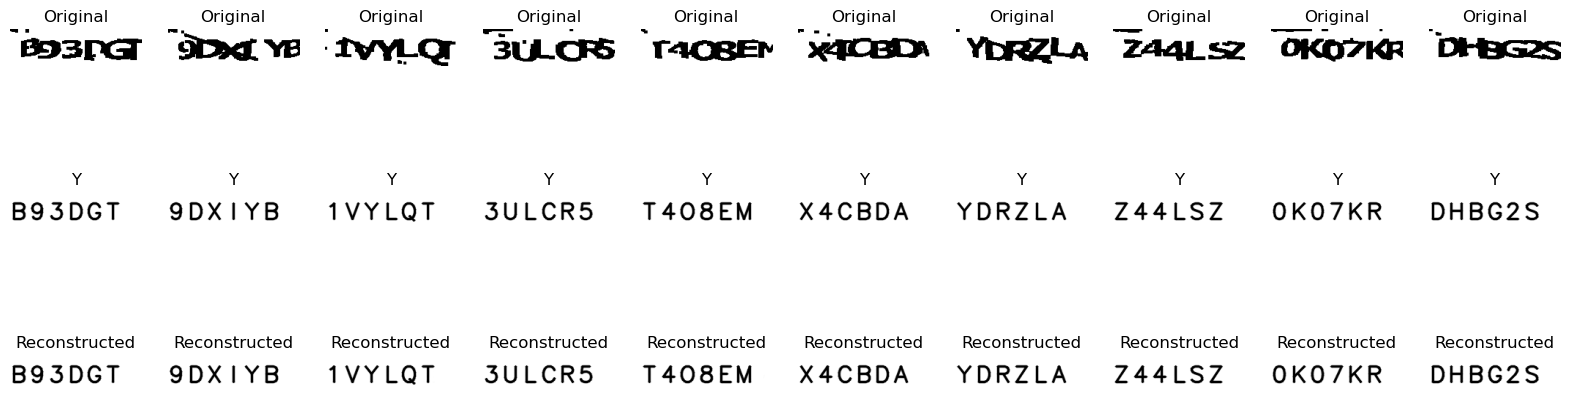

In [26]:
display_images(X_train, Y_train, Y_train_pred, num_images=10)

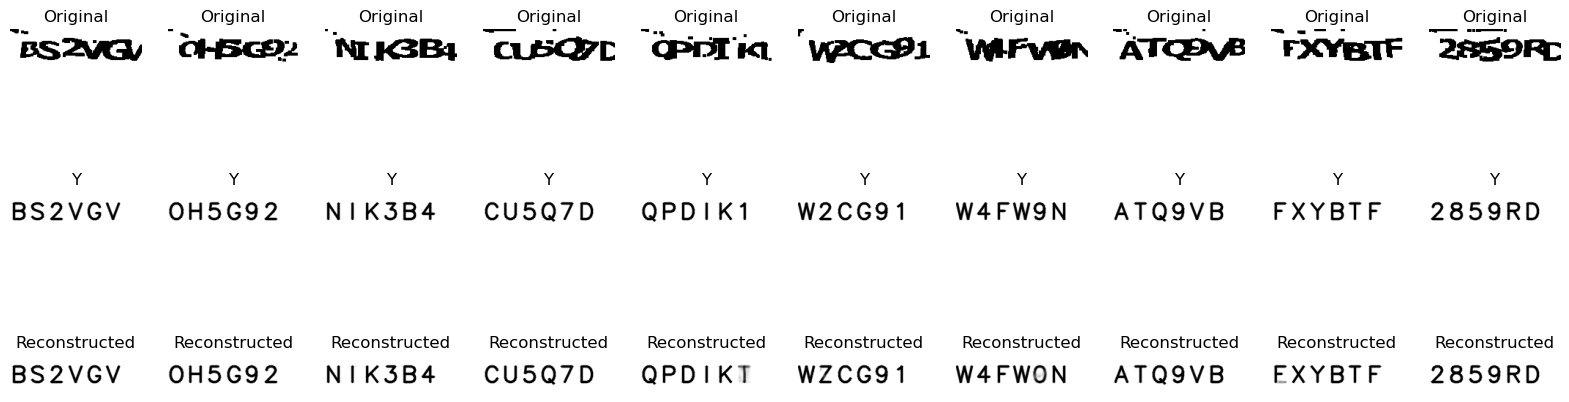

In [35]:
display_images(X_val, Y_val, Y_val_pred, num_images=10)

In [32]:
autoencoder.save('model_BCE_aug_200_unet.keras')